# MLZoomcamp 2022 Midterm Project

Author: José Victor

* Dataset: [Heart Failure Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)

## Imports

In [1]:
import sys

sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from utils import plot_roc_curve

## Loading data

In [2]:
df = pd.read_csv("../data/heart.csv")

In [3]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [4]:
new_columns_names = ["age",
                     "sex",
                     "chest_pain_type",
                     "resting_bp",
                     "cholesterol",
                     "fasting_bs",
                     "resting_ecg",
                     "max_hr",
                     "exercise_angina",
                     "oldpeak",
                     "st_slope",
                     "heart_disease"]

In [5]:
df.columns = new_columns_names

In [6]:
df.head()

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [7]:
df.isna().sum()

age                0
sex                0
chest_pain_type    0
resting_bp         0
cholesterol        0
fasting_bs         0
resting_ecg        0
max_hr             0
exercise_angina    0
oldpeak            0
st_slope           0
heart_disease      0
dtype: int64

In [8]:
df.duplicated().sum()

0

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              918 non-null    int64  
 1   sex              918 non-null    object 
 2   chest_pain_type  918 non-null    object 
 3   resting_bp       918 non-null    int64  
 4   cholesterol      918 non-null    int64  
 5   fasting_bs       918 non-null    int64  
 6   resting_ecg      918 non-null    object 
 7   max_hr           918 non-null    int64  
 8   exercise_angina  918 non-null    object 
 9   oldpeak          918 non-null    float64
 10  st_slope         918 non-null    object 
 11  heart_disease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [10]:
df.describe().round(2)

,age,resting_bp,cholesterol,fasting_bs,max_hr,oldpeak,heart_disease
count,918.00,918.00,918.00,918.00,918.00,918.00,918.00
mean,53.51,132.40,198.80,0.23,136.81,0.89,0.55
std,9.43,18.51,109.38,0.42,25.46,1.07,0.50
min,28.00,0.00,0.00,0.00,60.00,-2.60,0.00
25%,47.00,120.00,173.25,0.00,120.00,0.00,0.00
50%,54.00,130.00,223.00,0.00,138.00,0.60,1.00
75%,60.00,140.00,267.00,0.00,156.00,1.50,1.00
max,77.00,200.00,603.00,1.00,202.00,6.20,1.00


In [11]:
df.sex.value_counts()

M    725
F    193
Name: sex, dtype: int64

In [12]:
sex_map = {"F": 0,
           "M": 1}

df.sex = df.sex.map(sex_map)
df.sex = df.sex.astype(int)

In [13]:
df.chest_pain_type.value_counts()

ASY    496
NAP    203
ATA    173
TA      46
Name: chest_pain_type, dtype: int64

In [14]:
chest_pain_type_map = {"ASY": 0,
                       "NAP": 1,
                       "ATA": 2,
                       "TA": 3}

df.chest_pain_type = df.chest_pain_type.map(chest_pain_type_map)
df.chest_pain_type = df.chest_pain_type.astype(int)

In [15]:
df.resting_ecg.value_counts()

Normal    552
LVH       188
ST        178
Name: resting_ecg, dtype: int64

In [16]:
resting_ecg_map = {"Normal": 0,
                   "LVH": 1,
                   "ST": 2}

df.resting_ecg = df.resting_ecg.map(resting_ecg_map)
df.resting_ecg = df.resting_ecg.astype(int)

In [17]:
df.exercise_angina.value_counts()

N    547
Y    371
Name: exercise_angina, dtype: int64

In [18]:
exercise_angina_map = {"N": 0,
                       "Y": 1}

df.exercise_angina = df.exercise_angina.map(exercise_angina_map)
df.exercise_angina = df.exercise_angina.astype(int)

In [19]:
df.st_slope.value_counts()

Flat    460
Up      395
Down     63
Name: st_slope, dtype: int64

In [20]:
st_slop_map = {"Flat": 0,
               "Up": 1,
               "Down": 2}

df.st_slope = df.st_slope.map(st_slop_map)
df.st_slope = df.st_slope.astype(int)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              918 non-null    int64  
 1   sex              918 non-null    int64  
 2   chest_pain_type  918 non-null    int64  
 3   resting_bp       918 non-null    int64  
 4   cholesterol      918 non-null    int64  
 5   fasting_bs       918 non-null    int64  
 6   resting_ecg      918 non-null    int64  
 7   max_hr           918 non-null    int64  
 8   exercise_angina  918 non-null    int64  
 9   oldpeak          918 non-null    float64
 10  st_slope         918 non-null    int64  
 11  heart_disease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB


In [22]:
sns.set()

colors = sns.color_palette(n_colors=len(df.columns))

In [23]:
categorical_columns = ["sex", "chest_pain_type", "resting_ecg", "exercise_angina", "st_slope", "fasting_bs", "heart_disease"]

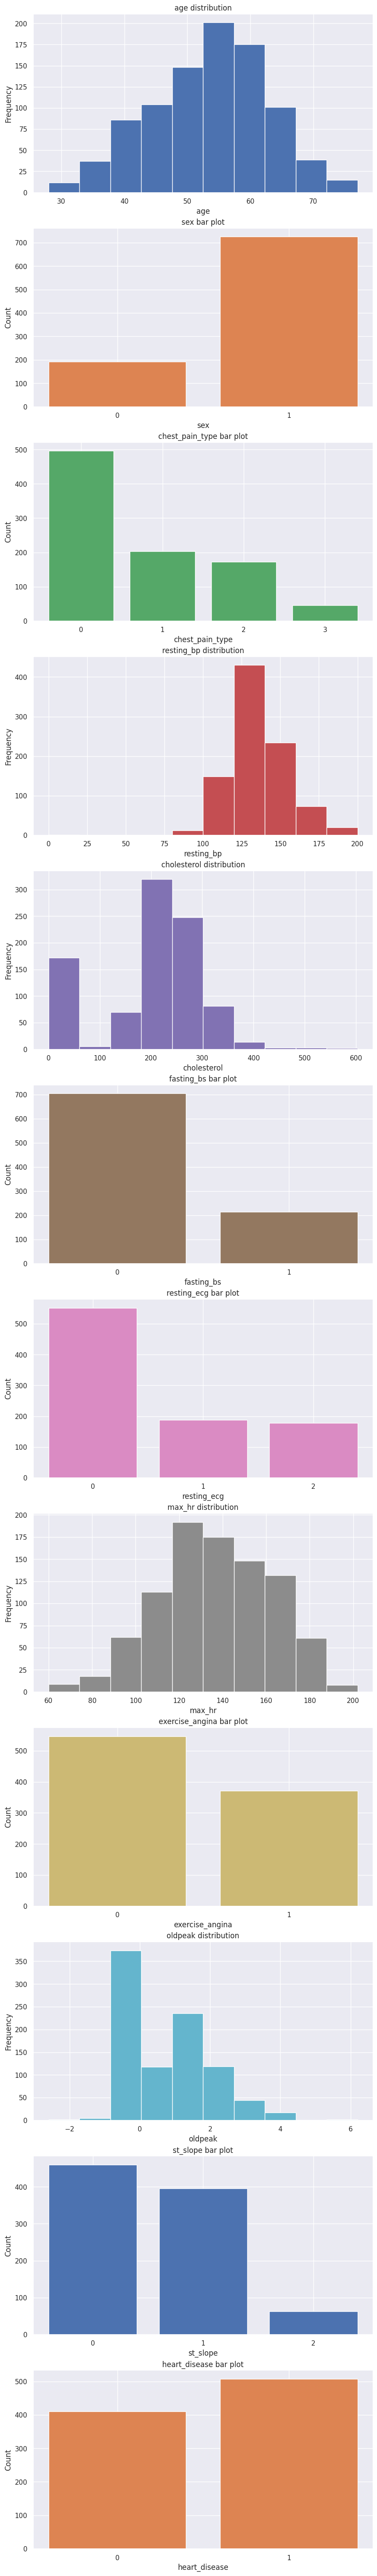

In [24]:
fig, ax = plt.subplots(nrows=len(df.columns))
fig.set_size_inches((10,75))

for idx, column in enumerate(df.columns):
    
    if column in categorical_columns:
        ax[idx].bar(x=df[column].value_counts().index, height=df[column].value_counts().values, color=colors[idx])
        ax[idx].set_title(f"{column} bar plot")
        ax[idx].set_xlabel(column)
        ax[idx].set_ylabel("Count")
        ax[idx].set_xticks(range(len(df[column].value_counts().index)))
    else:
        ax[idx].hist(df[column], color=colors[idx])
        ax[idx].set_title(f"{column} distribution")
        ax[idx].set_xlabel(column)
        ax[idx].set_ylabel("Frequency")
        
plt.show()

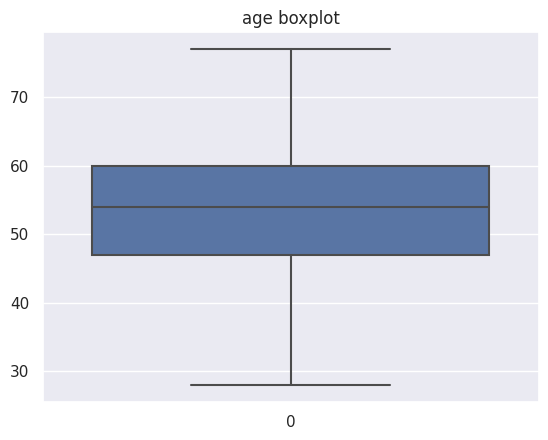

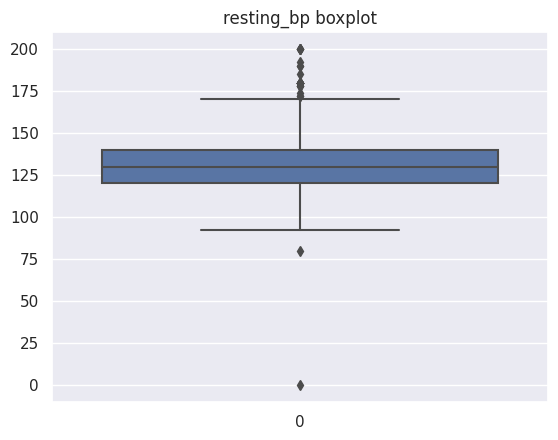

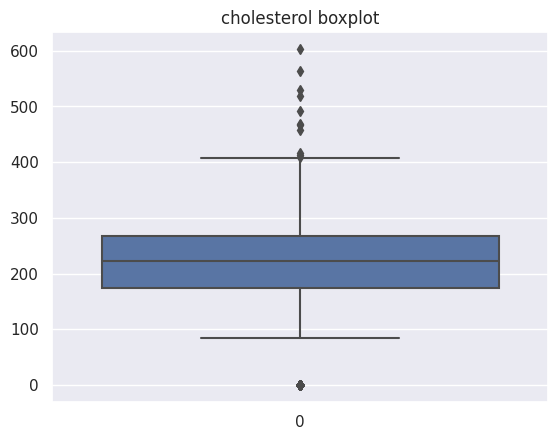

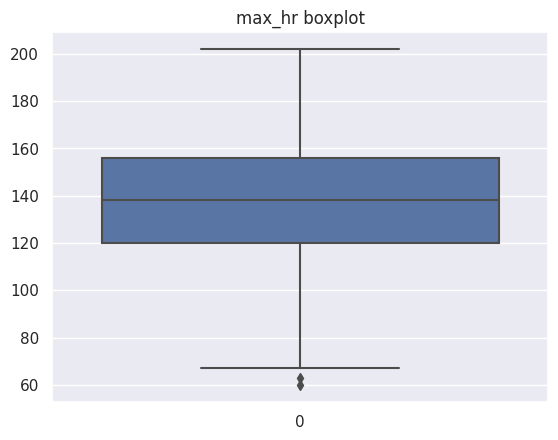

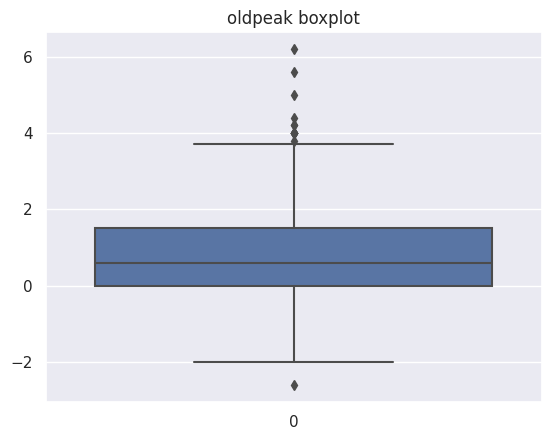

In [25]:
for column in df.columns:
    
    if column not in categorical_columns:
        sns.boxplot(data=df[column])
        plt.title(f"{column} boxplot")    
    plt.show()

In [26]:
df = df[~(df.cholesterol == 0)].copy()
df = df[~(df.resting_bp == 0)].copy()

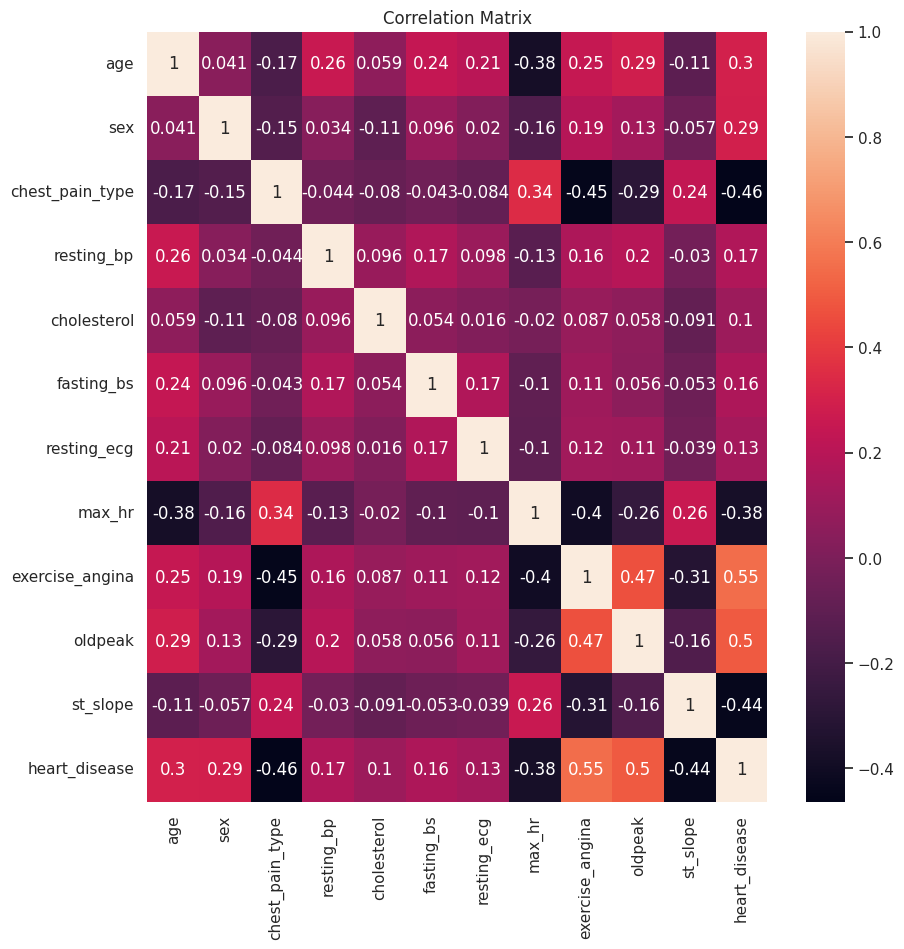

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches((10,10))

ax = sns.heatmap(data=df.corr(), annot=True)
ax.set_title("Correlation Matrix")
plt.show()

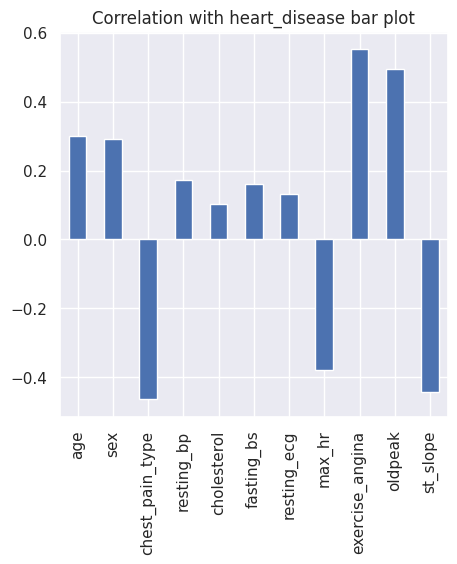

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches((5,5))

ax = df.drop("heart_disease", axis=1).corrwith(df.heart_disease).plot(kind="bar")
ax.set_title("Correlation with heart_disease bar plot")
plt.show()

In [29]:
data = df.copy()

COLUMNS = [col for col in data.columns if col != "heart_disease"]
TARGET = "heart_disease"

train_size = 0.6
test_size = 0.2
val_size = 0.2

X_full_train, X_test, y_full_train, y_test = train_test_split(data[COLUMNS],
                                                         data[TARGET],
                                                         test_size=test_size,
                                                         random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_full_train,
                                                  y_full_train,
                                                  test_size=val_size/(train_size+test_size),
                                                  random_state=42)

features_auc_scores = []

for column in COLUMNS:
    
    auc_score = roc_auc_score(y_true=y_train, y_score=X_train[column])
    features_auc_scores.append([column, auc_score])
    
feature_importance_df = pd.DataFrame(data=features_auc_scores, columns=["feature", "auc_score"])
feature_importance_df["correlation"] = data.drop("heart_disease", axis=1).corrwith(data.heart_disease).values

In [30]:
feature_importance_df.sort_values("auc_score", ascending=False)

,feature,auc_score,correlation
8,exercise_angina,0.784142,0.551834
9,oldpeak,0.768320,0.495696
0,age,0.654454,0.298617
3,resting_bp,0.617774,0.173242
1,sex,0.613242,0.292779
6,resting_ecg,0.566400,0.132872
4,cholesterol,0.553046,0.103866
5,fasting_bs,0.549722,0.160594
7,max_hr,0.272872,-0.377212
10,st_slope,0.243454,-0.441972


In [31]:
logistic_reg = LogisticRegression(solver="liblinear", C=1.0, max_iter=100, random_state=42)

In [32]:
FEATURES = ["exercise_angina", "oldpeak", "age", "sex", "chest_pain_type", "st_slope", "fasting_bs"]

train_size = 0.6
test_size = 0.2
val_size = 0.2

X_full_train, X_test, y_full_train, y_test = train_test_split(data[FEATURES],
                                                            data[TARGET],
                                                            test_size=test_size,
                                                            random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_full_train,
                                                    y_full_train,
                                                    test_size=val_size/(train_size+test_size),
                                                    random_state=42)

dv = DictVectorizer(sparse=False)

full_train_dict = X_full_train.to_dict(orient="records")
train_dict = X_train.to_dict(orient="records")
test_dict = X_test.to_dict(orient="records")
val_dict = X_val.to_dict(orient="records")

X_full_train = dv.fit_transform(full_train_dict)
X_train = dv.fit_transform(train_dict)
X_test = dv.fit_transform(test_dict)
X_val = dv.fit_transform(val_dict)

logistic_reg.fit(X=X_train, y=y_train)

y_pred = logistic_reg.predict(X=X_val)
auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
print(auc_score)

0.8635789093535572


## 1. LogisticRegression

### 1.1 Train and validation data

Hyperparameter tunning

In [33]:
c_values = [0.01, 0.1, 0.5, 1.0, 1.5, 10, 100]

for C in c_values:

    logistic_reg = LogisticRegression(solver="liblinear", C=C, max_iter=100, random_state=42)
    logistic_reg.fit(X=X_train, y=y_train)
    y_pred = logistic_reg.predict(X=X_val)
    auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
    print(f"C: {C} | score: {auc_score}")

C: 0.01 | score: 0.8174431202600215
C: 0.1 | score: 0.8373058866016613
C: 0.5 | score: 0.8635789093535572
C: 1.0 | score: 0.8635789093535572
C: 1.5 | score: 0.8635789093535572
C: 10 | score: 0.8494944023113036
C: 100 | score: 0.8494944023113036


In [34]:
logistic_reg = LogisticRegression(solver="liblinear", C=0.5, max_iter=100, random_state=42)
logistic_reg.fit(X=X_train, y=y_train)
y_pred = logistic_reg.predict(X=X_val)
auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
print(auc_score)

0.8635789093535572


Confusion matrix

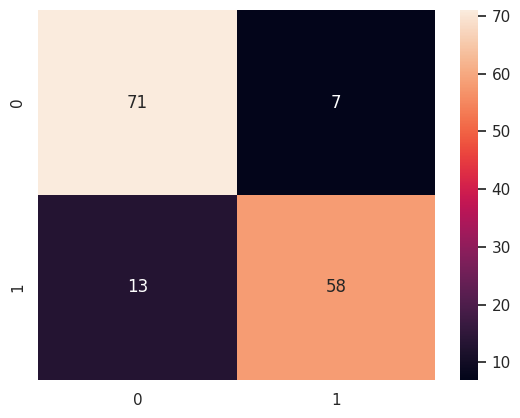

In [35]:
sns.heatmap(confusion_matrix(y_true=y_val, y_pred=y_pred), annot=True)
plt.show()

Classification report

In [36]:
print(classification_report(y_true=y_val, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88        78
           1       0.89      0.82      0.85        71

    accuracy                           0.87       149
   macro avg       0.87      0.86      0.86       149
weighted avg       0.87      0.87      0.87       149



ROC curve

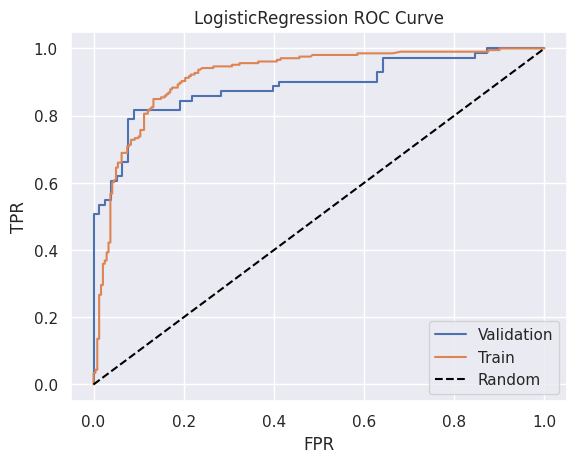

In [37]:
plot_roc_curve(model=logistic_reg, 
               data1=(X_val, y_val), 
               data1_label="Validation",
               data2=(X_train, y_train),
               data2_label="Train",
               title="LogisticRegression ROC Curve")

### 1.2 Full train and test data

In [38]:
logistic_reg = LogisticRegression(solver="liblinear", C=0.5, max_iter=100, random_state=42)
logistic_reg.fit(X=X_full_train, y=y_full_train)
y_pred = logistic_reg.predict(X=X_test)
auc_score = roc_auc_score(y_true=y_test.values, y_score=y_pred)
print(auc_score)

0.8684257443394545


Confusion matrix

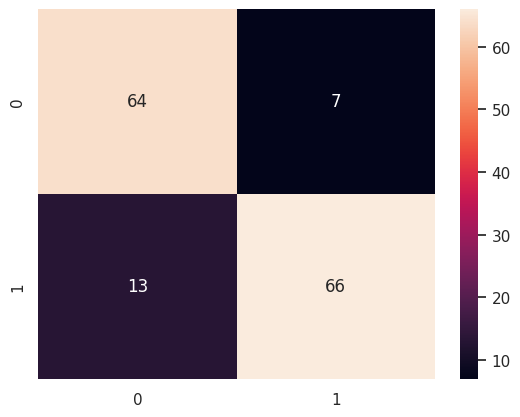

In [39]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), annot=True)
plt.show()

Classification report

In [40]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86        71
           1       0.90      0.84      0.87        79

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



ROC curve

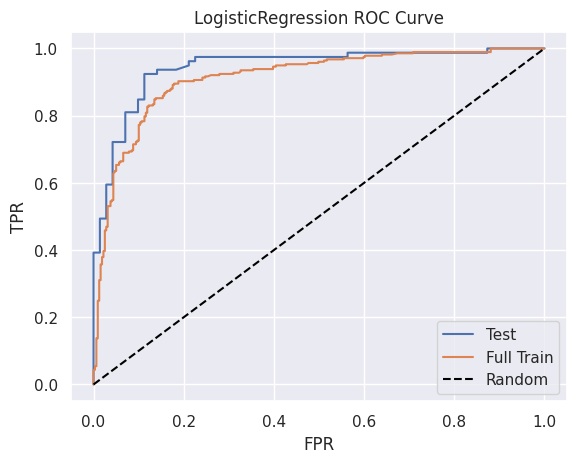

In [41]:
plot_roc_curve(model=logistic_reg, 
               data1=(X_test, y_test), 
               data1_label="Test",
               data2=(X_full_train, y_full_train),
               data2_label="Full Train",
               title="LogisticRegression ROC Curve")

## 2. DecisionTreeClassifier

### 2.1 Train and validation data

In [42]:
dt = DecisionTreeClassifier(random_state=42)

In [43]:
dt.fit(X=X_train, y=y_train)

DecisionTreeClassifier(random_state=42)

In [44]:
y_pred = dt.predict(X=X_val)
auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
print(auc_score)

0.8104008667388949


Hyperparemeters tunning

In [45]:
criterion_list = ["gini", "entropy", "log_loss"]

for criterion in criterion_list:
    
    dt = DecisionTreeClassifier(criterion=criterion, random_state=42)
    dt.fit(X=X_train, y=y_train)
    y_pred = dt.predict(X=X_val)
    auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
    print(f"criterion: {criterion} | score: {auc_score}")
    

criterion: gini | score: 0.8104008667388949
criterion: entropy | score: 0.755958829902492
criterion: log_loss | score: 0.755958829902492


In [46]:
max_depth_list = [1,2,3,4,5,6,7,8,9,10,15,20,25,50,100,200]

for max_depth in max_depth_list:
    
    dt = DecisionTreeClassifier(criterion="gini", max_depth=max_depth, random_state=42)
    dt.fit(X=X_train, y=y_train)
    y_pred = dt.predict(X=X_val)
    auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
    print(f"max_depth: {max_depth} | score: {auc_score}")

max_depth: 1 | score: 0.7463885879378839
max_depth: 2 | score: 0.8077825929938606
max_depth: 3 | score: 0.8584326471650415
max_depth: 4 | score: 0.8366738894907908
max_depth: 5 | score: 0.8097688696280245
max_depth: 6 | score: 0.8232213795594077
max_depth: 7 | score: 0.8085048754062838
max_depth: 8 | score: 0.8232213795594077
max_depth: 9 | score: 0.8161791260382809
max_depth: 10 | score: 0.7892741061755146
max_depth: 15 | score: 0.8104008667388949
max_depth: 20 | score: 0.8104008667388949
max_depth: 25 | score: 0.8104008667388949
max_depth: 50 | score: 0.8104008667388949
max_depth: 100 | score: 0.8104008667388949
max_depth: 200 | score: 0.8104008667388949


In [47]:
min_samples_leaf_list = [1,2,3,4,5,6,7,8,9,10,15,20,25,50,100,200]

for min_samples_leaf in min_samples_leaf_list:
    
    dt = DecisionTreeClassifier(criterion="gini", max_depth=3, min_samples_leaf=min_samples_leaf, random_state=42)
    dt.fit(X=X_train, y=y_train)
    y_pred = dt.predict(X=X_val)
    auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
    print(f"min_samples_leaf: {min_samples_leaf} | score: {auc_score}")

min_samples_leaf: 1 | score: 0.8584326471650415
min_samples_leaf: 2 | score: 0.8584326471650415
min_samples_leaf: 3 | score: 0.8584326471650415
min_samples_leaf: 4 | score: 0.8584326471650415
min_samples_leaf: 5 | score: 0.8584326471650415
min_samples_leaf: 6 | score: 0.8584326471650415
min_samples_leaf: 7 | score: 0.8315276273022751
min_samples_leaf: 8 | score: 0.8315276273022751
min_samples_leaf: 9 | score: 0.8315276273022751
min_samples_leaf: 10 | score: 0.8315276273022751
min_samples_leaf: 15 | score: 0.8379378837125316
min_samples_leaf: 20 | score: 0.8263813651137595
min_samples_leaf: 25 | score: 0.8263813651137595
min_samples_leaf: 50 | score: 0.8077825929938606
min_samples_leaf: 100 | score: 0.7463885879378839
min_samples_leaf: 200 | score: 0.8033586132177681


In [48]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=3, min_samples_leaf=1, random_state=42)
dt.fit(X=X_train, y=y_train)
y_pred = dt.predict(X=X_val)
auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
print(auc_score)

0.8584326471650415


Confusion matrix

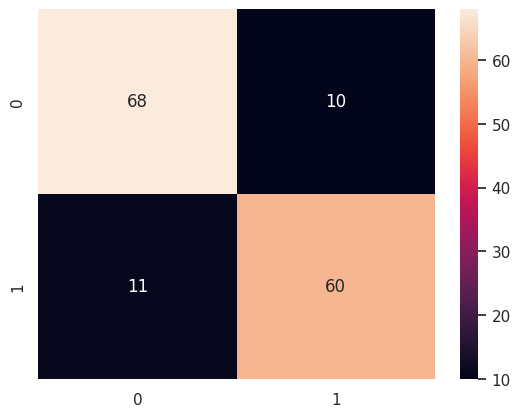

In [49]:
sns.heatmap(confusion_matrix(y_true=y_val, y_pred=y_pred), annot=True)
plt.show()

Classification report

In [50]:
print(classification_report(y_true=y_val, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.87        78
           1       0.86      0.85      0.85        71

    accuracy                           0.86       149
   macro avg       0.86      0.86      0.86       149
weighted avg       0.86      0.86      0.86       149



ROC curve

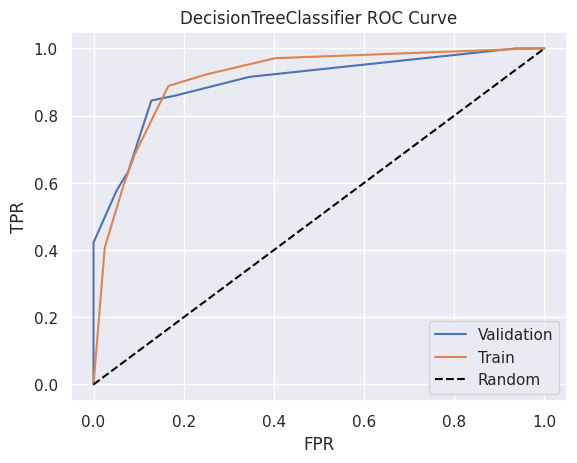

In [51]:
plot_roc_curve(model=dt, 
               data1=(X_val, y_val), 
               data1_label="Validation",
               data2=(X_train, y_train),
               data2_label="Train",
               title="DecisionTreeClassifier ROC Curve")

### 2.2 Full train and test data 

In [52]:
dt = DecisionTreeClassifier(criterion="gini", max_depth=3, min_samples_leaf=1, random_state=42)
dt.fit(X=X_full_train, y=y_full_train)
y_pred = dt.predict(X=X_test)
auc_score = roc_auc_score(y_true=y_test.values, y_score=y_pred)
print(auc_score)

0.9000713139597076


Confusion matrix

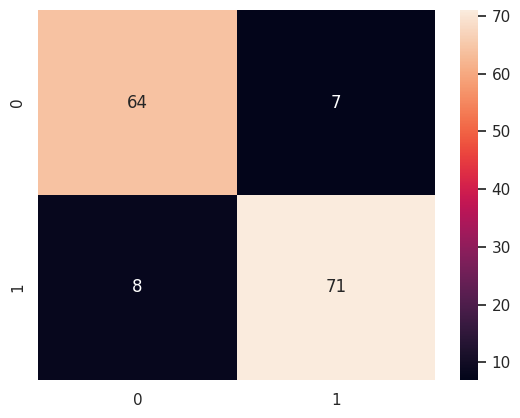

In [53]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), annot=True)
plt.show()

Classification report

In [54]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90        71
           1       0.91      0.90      0.90        79

    accuracy                           0.90       150
   macro avg       0.90      0.90      0.90       150
weighted avg       0.90      0.90      0.90       150



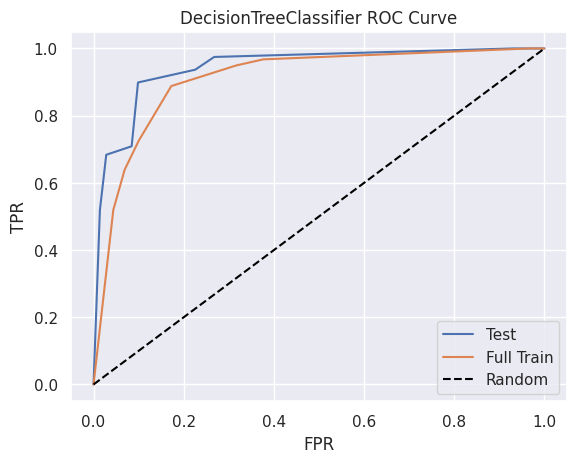

In [55]:
plot_roc_curve(model=dt, 
               data1=(X_test, y_test), 
               data1_label="Test",
               data2=(X_full_train, y_full_train),
               data2_label="Full Train",
               title="DecisionTreeClassifier ROC Curve")

## 3. RandomForestClassifier

### 3.1 Train and validation data

In [56]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

In [57]:
rf.fit(X=X_train, y=y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [58]:
y_pred = rf.predict(X=X_val)
auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
print(auc_score)

0.8302636330805344


Hyperparameters tunning

In [59]:
criterion_list = ["gini", "entropy", "log_loss"]

for criterion in criterion_list:
    
    rf = RandomForestClassifier(n_estimators=100, criterion=criterion, random_state=42, n_jobs=-1)
    rf.fit(X=X_train, y=y_train)
    y_pred = rf.predict(X=X_val)
    auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
    print(f"criterion: {criterion} | score: {auc_score}")
    

criterion: gini | score: 0.8302636330805344
criterion: entropy | score: 0.8430841459010472
criterion: log_loss | score: 0.8430841459010472


In [60]:
n_estimators_list = [1, 5, 10, 25, 50, 75, 100, 250, 500, 1000, 2000]

for n_estimator in n_estimators_list:
    
    rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=5, criterion="entropy", random_state=42, n_jobs=-1)
    rf.fit(X=X_train, y=y_train)
    y_pred = rf.predict(X=X_val)
    auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
    print(f"n_estimator: {n_estimator} | score: {auc_score}")

n_estimator: 1 | score: 0.7963163596966414
n_estimator: 5 | score: 0.8373058866016613
n_estimator: 10 | score: 0.8565366558324304
n_estimator: 25 | score: 0.8366738894907908
n_estimator: 50 | score: 0.8507583965330444
n_estimator: 75 | score: 0.8507583965330444
n_estimator: 100 | score: 0.8507583965330444
n_estimator: 250 | score: 0.8507583965330444
n_estimator: 500 | score: 0.8507583965330444
n_estimator: 1000 | score: 0.8507583965330444
n_estimator: 2000 | score: 0.8507583965330444


In [61]:
max_depth_list = [1,2,3,4,5,10,15,20,25,50,75,100,200]

for max_depth in max_depth_list:
    
    rf = RandomForestClassifier(n_estimators=10, criterion="entropy", max_depth=max_depth, random_state=42, n_jobs=-1)
    rf.fit(X=X_train, y=y_train)
    y_pred = rf.predict(X=X_val)
    auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
    print(f"max_depth: {max_depth} | score: {auc_score}")

max_depth: 1 | score: 0.8424521487901768
max_depth: 2 | score: 0.8180751173708921
max_depth: 3 | score: 0.8373058866016613
max_depth: 4 | score: 0.844348140122788
max_depth: 5 | score: 0.8565366558324304
max_depth: 10 | score: 0.8308956301914049
max_depth: 15 | score: 0.8161791260382809
max_depth: 20 | score: 0.8232213795594077
max_depth: 25 | score: 0.8232213795594077
max_depth: 50 | score: 0.8232213795594077
max_depth: 75 | score: 0.8232213795594077
max_depth: 100 | score: 0.8232213795594077
max_depth: 200 | score: 0.8232213795594077


In [62]:
rf = RandomForestClassifier(n_estimators=10, criterion="entropy", max_depth=5, max_features="sqrt", random_state=42, n_jobs=-1)
rf.fit(X=X_train, y=y_train)
y_pred = rf.predict(X=X_val)
auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
print(auc_score)

0.8565366558324304


Confusion matrix

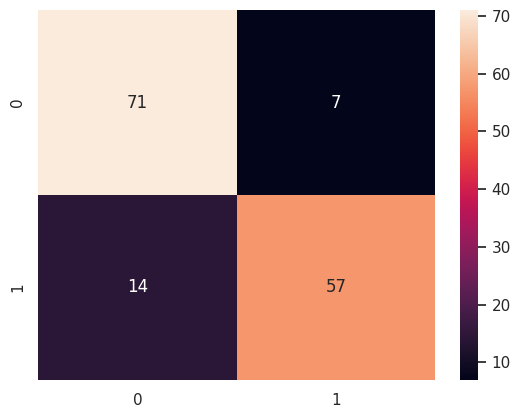

In [63]:
sns.heatmap(confusion_matrix(y_true=y_val, y_pred=y_pred), annot=True)
plt.show()

Classification report

In [64]:
print(classification_report(y_true=y_val, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87        78
           1       0.89      0.80      0.84        71

    accuracy                           0.86       149
   macro avg       0.86      0.86      0.86       149
weighted avg       0.86      0.86      0.86       149



ROC curve

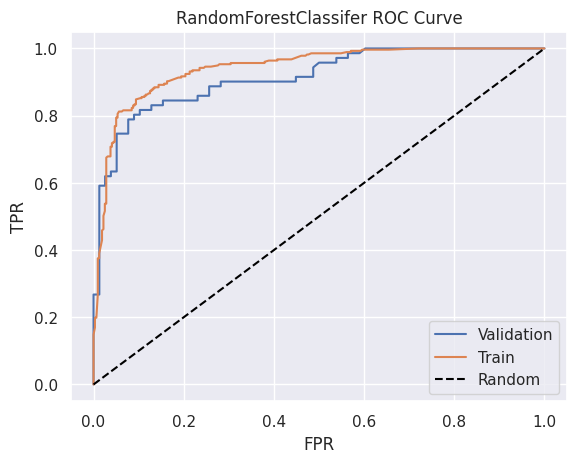

In [65]:
plot_roc_curve(model=rf, 
               data1=(X_val, y_val), 
               data1_label="Validation",
               data2=(X_full_train, y_full_train),
               data2_label="Train",
               title="RandomForestClassifer ROC Curve")

### 3.2 Full train and test data

In [66]:
rf = RandomForestClassifier(n_estimators=10, criterion="gini", max_depth=5, max_features="sqrt", random_state=42, n_jobs=-1)
rf.fit(X=X_full_train, y=y_full_train)
y_pred = rf.predict(X=X_test)
auc_score = roc_auc_score(y_true=y_test.values, y_score=y_pred)
print(auc_score)

0.8635229096095561


Confusion matrix

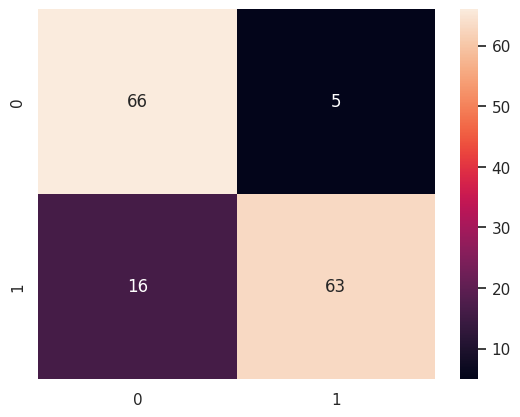

In [67]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), annot=True)
plt.show()

Classification report

In [68]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.80      0.93      0.86        71
           1       0.93      0.80      0.86        79

    accuracy                           0.86       150
   macro avg       0.87      0.86      0.86       150
weighted avg       0.87      0.86      0.86       150



ROC curve

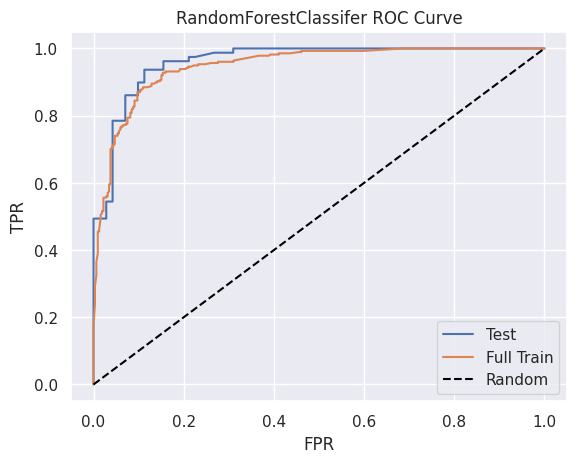

In [69]:
plot_roc_curve(model=rf, 
               data1=(X_test, y_test), 
               data1_label="Test",
               data2=(X_full_train, y_full_train),
               data2_label="Full Train",
               title="RandomForestClassifer ROC Curve")

## 4. XGBClassifier

### 4.1 Train and validation data

In [70]:
xgb_cl = xgb.XGBClassifier()

In [71]:
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [72]:
y_pred = xgb_cl.predict(X_val)
auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
print(auc_score)

0.7950523654749007


Hyperparameters tunning

In [73]:
n_estimators_list = [1, 5, 10, 15, 20, 25, 50, 100, 200, 500, 1000, 2000]

for n_estimator in n_estimators_list:
    
    xgb_cl = xgb.XGBClassifier(objective="binary:logistic", 
                           n_estimators = n_estimator
                           )
    xgb_cl.fit(X_train, y_train)
    y_pred = xgb_cl.predict(X_val)
    auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
    print(f"n_estimator: {n_estimator} | score: {auc_score}")

n_estimator: 1 | score: 0.7623690863127482
n_estimator: 5 | score: 0.8437161430119177
n_estimator: 10 | score: 0.8360418923799205
n_estimator: 15 | score: 0.8155471289274105
n_estimator: 20 | score: 0.8289996388587938
n_estimator: 25 | score: 0.8091368725171542
n_estimator: 50 | score: 0.8161791260382809
n_estimator: 100 | score: 0.7950523654749007
n_estimator: 200 | score: 0.8225893824485373
n_estimator: 500 | score: 0.7899061032863849
n_estimator: 1000 | score: 0.8097688696280245
n_estimator: 2000 | score: 0.829631635969664


In [74]:
max_depth_list = [1,2,3,4,5,6,7,8,9,10,20,50]

for max_depth in max_depth_list:
    
    xgb_cl = xgb.XGBClassifier(objective="binary:logistic", 
                           n_estimators = 5,
                           max_depth=max_depth
                           )
    xgb_cl.fit(X_train, y_train)
    y_pred = xgb_cl.predict(X_val)
    auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
    print(f"max_depth: {max_depth} | score: {auc_score}")

max_depth: 1 | score: 0.8366738894907908
max_depth: 2 | score: 0.8244853737811484
max_depth: 3 | score: 0.8308956301914049
max_depth: 4 | score: 0.8373058866016613
max_depth: 5 | score: 0.8302636330805344
max_depth: 6 | score: 0.8437161430119177
max_depth: 7 | score: 0.8385698808234019
max_depth: 8 | score: 0.8385698808234019
max_depth: 9 | score: 0.8385698808234019
max_depth: 10 | score: 0.8385698808234019
max_depth: 20 | score: 0.8385698808234019
max_depth: 50 | score: 0.8385698808234019


In [75]:
learning_rate_list = [0.3, 0.29, 0.28, 0.27, 0.26, 0.25, 0.2, 0.15, 0.1, 0.01]

for lr in learning_rate_list:
    
    xgb_cl = xgb.XGBClassifier(objective="binary:logistic", 
                           learning_rate=lr,
                           n_estimators=5,
                           max_depth=6
                           )
    xgb_cl.fit(X_train, y_train)
    y_pred = xgb_cl.predict(X_val)
    auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
    print(f"learning rate: {lr} | score: {auc_score}")

learning rate: 0.3 | score: 0.8437161430119177
learning rate: 0.29 | score: 0.8232213795594077
learning rate: 0.28 | score: 0.8513903936439148
learning rate: 0.27 | score: 0.8513903936439148
learning rate: 0.26 | score: 0.8373058866016613
learning rate: 0.25 | score: 0.8373058866016613
learning rate: 0.2 | score: 0.8373058866016613
learning rate: 0.15 | score: 0.8033586132177681
learning rate: 0.1 | score: 0.7892741061755146
learning rate: 0.01 | score: 0.7764535933550019


In [76]:
xgb_cl = xgb.XGBClassifier(objective="binary:logistic", 
                           learning_rate=0.27,
                           n_estimators=5,
                           max_depth=6
                           )

In [77]:
xgb_cl.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.27, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=5, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [78]:
y_pred = xgb_cl.predict(X_val)
auc_score = roc_auc_score(y_true=y_val.values, y_score=y_pred)
print(auc_score)

0.8513903936439148


Confusion matrix

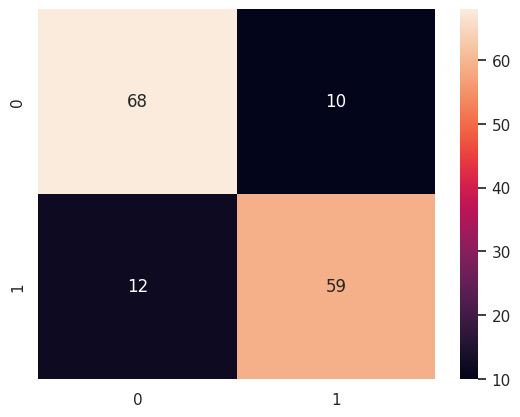

In [79]:
sns.heatmap(confusion_matrix(y_true=y_val, y_pred=y_pred), annot=True)
plt.show()

Classification report

In [80]:
print(classification_report(y_true=y_val, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        78
           1       0.86      0.83      0.84        71

    accuracy                           0.85       149
   macro avg       0.85      0.85      0.85       149
weighted avg       0.85      0.85      0.85       149



ROC curve

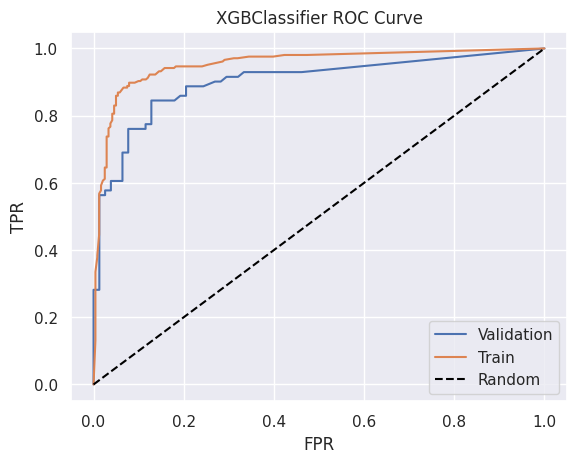

In [81]:
plot_roc_curve(model=xgb_cl, 
               data1=(X_val, y_val), 
               data1_label="Validation",
               data2=(X_train, y_train),
               data2_label="Train",
               title="XGBClassifier ROC Curve")

### 4.2 Full train and test data

In [82]:
xgb_cl = xgb.XGBClassifier(objective="binary:logistic", 
                           learning_rate=0.27,
                           n_estimators=5,
                           max_depth=6
                           )
xgb_cl.fit(X_full_train, y_full_train)
y_pred = xgb_cl.predict(X_test)
auc_score = roc_auc_score(y_true=y_test.values, y_score=y_pred)
print(auc_score)

0.8691388839365305


Confusion matrix

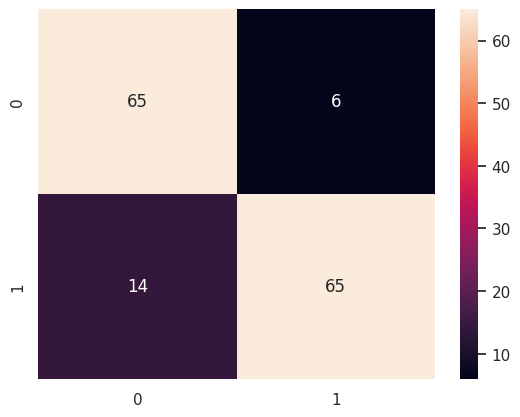

In [83]:
sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), annot=True)
plt.show()

Classification report

In [84]:
print(classification_report(y_true=y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.82      0.92      0.87        71
           1       0.92      0.82      0.87        79

    accuracy                           0.87       150
   macro avg       0.87      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



ROC curve

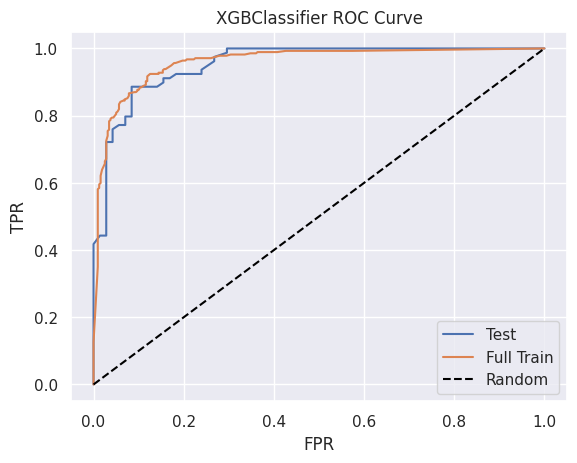

In [85]:
plot_roc_curve(model=xgb_cl, 
               data1=(X_test, y_test), 
               data1_label="Test",
               data2=(X_full_train, y_full_train),
               data2_label="Full Train",
               title="XGBClassifier ROC Curve")